**The data below consists of a training set and four different test sets stored in the file `animals.pkl`. The images in the training set are clean animal images, while those in the test sets are transformed animal images. The code below loads the data. A few example images are shown.**

image size = (80, 80) ; max value = 1.0 ; min value = 0.0
training examples


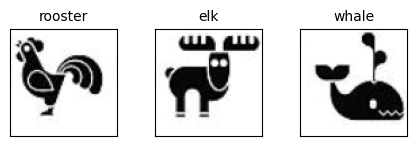

test set rot - randomly rotated images


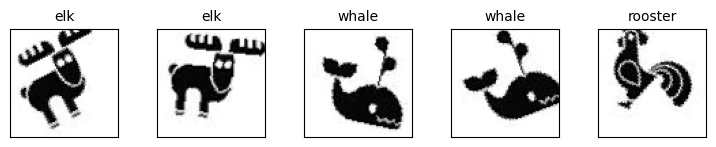

test set cut - one quadrant cut off


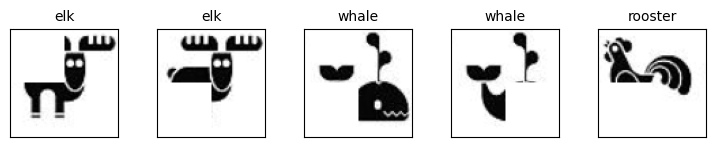

test set p4 - each pixel value v flipped to 1-v with probability 0.4


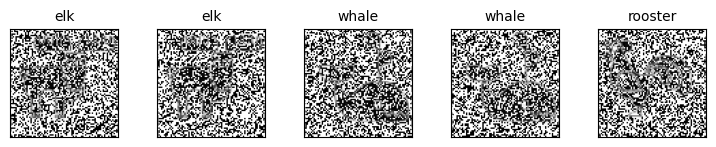

test set p6 - each pixel value v flipped to 1-v with probability 0.6


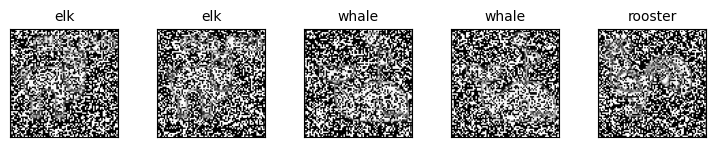

In [1]:
from util import *
import pickle as pkl

animals = pkl.load(open('animals.pkl', 'rb'))

image = animals['x_tr'][0]
print('image size =', image.shape, '; max value =', image.max(), '; min value =', image.min())

print('training examples')
x_tr, y_tr = animals['x_tr'], animals['y_tr']
plot_gallery(animals['x_tr'], titles=animals['y_tr'])

print('test set rot - randomly rotated images')
x_ts_rot, y_ts_rot = animals['x_ts_rot'], animals['y_ts_rot']
plot_gallery(animals['x_ts_rot'][:5], titles=animals['y_ts_rot'][:5])

print('test set cut - one quadrant cut off')
x_ts_cut, y_ts_cut = animals['x_ts_cut'], animals['y_ts_cut']
plot_gallery(x_ts_cut[:5], titles=y_ts_cut[:5])

print('test set p4 - each pixel value v flipped to 1-v with probability 0.4')
x_ts_p4, y_ts_p4 = animals['x_ts_p4'], animals['y_ts_p4']
plot_gallery(x_ts_p4[:5], titles=y_ts_p4[:5])

print('test set p6 - each pixel value v flipped to 1-v with probability 0.6')
x_ts_p6, y_ts_p6 = animals['x_ts_p6'], animals['y_ts_p6']
plot_gallery(x_ts_p6[:5], titles=y_ts_p6[:5])

### Hopfield networks

<b> Here, I implement a recurrent Hopfield neural network from scratch (using only Numpy) which satisfies the following:
- The network is trained on binary images.
- The network can classify binary images.
- The network terminates the reconstruction process once the recontructed image does not change any more.
</b>

**Note that here each binary image is a 2D array with entries being either 0 or 1.**

In [3]:
import numpy as np

def sgn(x):
    if x >= 0:
        x = 1
    else:
        x = -1
    return x  
    
class HopfieldNet:
    """
    A Hopfield Network class.
    
    Example
    -------
    >>> net = HopfieldNet()
    >>> net.fit(images, labels) # see fit on requirements on images and labels
    >>> print("Training accuracy:", net.score(images, labels))
    """

    def __init__(self):
        pass
    
    # Require BINARY images to be a np.array w/ shape = (n,m)
    # labels are a np.array w/ shape (n,)
    def fit(self, train_images, train_labels=None):
        """
        Train a Hopfield network.
        
        Parameters
        ----------
        images: An array of 2D binary images. Each pixel value is either 0 or 1.
        labels: An optional 1D array of labels for the images. Required for classify and score.
        """
        # Training set images
        self.train_images = np.array(train_images)
        
        # These are labels of the training set
        self.train_labels = train_labels

        # We have m neurons, and self.images is an n x m binarized numpy array
        m = train_images.shape[1]
        
        # Converting 1's and 0's into 1's and -1's 
        a = np.array([(2*train_images[:,i]-1) for i in range(train_images.shape[1])])
        
        # Constructing our W matrix
        self.w_ij = a @ a.T
        np.fill_diagonal(self.w_ij, 0)
        
    # Require BINARY test images to be a np.array w/ shape = (n,m)
    # labels are a np.array w/ shape (n,)
    def predict(self, test_images, sync=True, niter=100, verbose=False):
        """
        Compute and return the reconstrutions for the given images.
        
        Parameters
        ----------
        images: An array of 2D binary images. Each pixel value is either 0 or 1.
        sync: Use synchrounous update if True, and semi-random update if False.
        niter: Maximum number of iterations used for computing a reconstruction. 
            An iteration involves updating each neuron once. Stop the reconstruction
            process once the patterns do not change any more in an iteration.
        verbose: Print debug messages if set to True. Put any debug message under "if verbose:" block.
        
        Returns
        -------
        reconstructions: an array of reconstructed 2D binary image. Each pixel value is either 0 or 1.
        """
        # images is an n x m array of binary images
        m = test_images.shape[1]
        
        # Reconstructions will be a np.array of shape n x m, where the nth row is a row of 0s and 1s 
        # corresponding to the reconstructed image of the nth example.
        reconstructions = []
        
        # Given images has shape (n,m),
        # This will iterate over the n rows in 'images' as desired
        for idx, test_image in enumerate(test_images):

            #STEP 3B: NEED to convert inputted binary example from 1, 0, 0 ,1 --> 1, -1, -1, 1
            test_image = np.array([1 if x == 1 else -1 for x in test_image])
            
            # We will set converged = True 
            # if reconstruction on niter - 1 == reconstruction on n_iter
            converged = False
            
            ######### synchronous update #########
            if sync:

                old_activations = np.array([test_image[i] for i in range(m)])
                update_activations = np.zeros(m)
                
                ######### synchronous update #########
                for j in range(niter):

                    # Looping over m neurons
                    # to do simultaneous updates on m neurons
                    for i in range(m):
                        update_activations[i] = sgn((np.dot(self.w_ij[i], old_activations)))

                    if np.array_equal(update_activations, old_activations):
                        
                        ### STEP 4. Binarize converged non-binary prediction 1, -1, -1, 1 ---- > 1, 0, 0 ,1 
                        nbin_output = update_activations
                        bin_output = (nbin_output > 0).astype(int)
                        
                        reconstructions.append(bin_output)
                        converged = True
                        break #breaks the for loop looping over niters 
                        
                    else:
                        old_activations = np.array([update_activations[i] for i in range(update_activations.shape[0])])
                       
            ########## semi-random update #########
            else:

                old_activations = np.array([test_image[i] for i in range(m)])
                update_activations = np.array([test_image[i] for i in range(m)])
                sequence = np.arange(m)
                
                ########## semi-random update #########
                for j in range(niter):

                    for i in sequence:
                        update_activations[i] = sgn(np.dot(self.w_ij[i], update_activations))
                    # Shuffle sequence of neurons after one iteration
                    np.random.shuffle(sequence)

                    if np.array_equal(update_activations, old_activations):
                        ### STEP 4. Binarize converged non-binary prediction 1, -1, -1, 1 ---- > 1, 0, 0 ,1 
                        nbin_output = update_activations
                        bin_output = (nbin_output > 0).astype(int)
                    
                        reconstructions.append(bin_output)
                        converged = True
                        break #breaks the for loop looping over niters 
                        
                    else:
                        old_activations = np.array([update_activations[i] for i in range(update_activations.shape[0])])
                        
            if verbose:
                if converged:
                    print(f"Img {idx + 1} converged in {j+1} iterations")
                else:
                    print(f"Img {idx + 1} update did not converge in {j+1} iterations")
                    
        return np.array(reconstructions)

    def classify(self, test_images, p6, **kwargs):
        """
        Classify images. To classify an image, first compute its reconstruction, then predict
        its class to be the reconstruction's nearest training example's label.
        
        Parameters
        ----------
        images: An array of 2D binary images. Each pixel value is either 0 or 1.
        kwargs: These are keyword arguments that are accepted by the predict function.
        
        Returns
        -------
        labels: An array of predicted class labels.
        """
        assert self.train_labels is not None # training labels need to be provided when using fit to train the model
        
        # Compute reconstructions of test binary images
        reconstructions = self.predict(test_images, **kwargs)
        
        # initialising output list of predicted labels
        predictedlabels = []
        
        # Loop over all reconstructions to retrieve label
        for i in range(reconstructions.shape[0]):
            
            predictedlabel = self.l1norm(reconstructions[i], p6)
            predictedlabels.append(predictedlabel)

        return np.array(predictedlabels)
    
    # Returns the label of the training example
    # that minimizes/maximizes (if p6 = False/True) the l1norm for the ith reconstructed image
    def l1norm(self, reconstruction, p6):

        l1norms = []

        # loop over all images and compute l1_norm for all images.shape[0] = 300 images
        for i in range(self.train_images.shape[0]):
            l1norm = np.sum(np.abs(reconstruction-self.train_images[i]))
            l1norms.append(l1norm)
        
        l1norms = np.array(l1norms)
        
        # compute the argmax(l1norm) for p6 = True ---> because black/white are 'inverted'
        # compared to original training images
        if p6:
            label_idx = np.argmax(l1norms)
            
        # compute the argmin(l1norm) for p6 = False (I.E. all datasets != Xp6)
        else:
            label_idx = np.argmin(l1norms)
            
        return self.train_labels[label_idx]

    # Images has (300, 6400) shape
    # Labels has (300, ) shape
    def score(self, test_images, test_labels, num_imgs = 300, p6 = True, **kwargs):
        """
        Returns the classification accuracy on the given dataset.
        """
        return np.mean(self.classify(test_images[:num_imgs], p6, **kwargs) == test_labels[:num_imgs])

**Here, I train my Hopfied network using training examples.**

In [6]:
# Reshaping our various test and training sets from
# (n, 80, 80), where n = # of examples, to (n, 6400).

# So the nth row is a vector of 6400 pixels belonging to the nth example.
Xtr = x_tr.reshape(x_tr.shape[0],-1)
Xrot = x_ts_rot.reshape(x_ts_rot.shape[0],-1)
Xcut = x_ts_cut.reshape(x_ts_cut.shape[0],-1)
Xp4 = x_ts_p4.reshape(x_ts_p4.shape[0],-1)
Xp6 = x_ts_p6.reshape(x_ts_p6.shape[0],-1)

# Define ground truth labels to be of shape (n,)
ytr = y_tr
yrot = y_ts_rot
ycut = y_ts_cut
yp4 = y_ts_p4
yp6 = y_ts_p6

# PROCEDURE
'''
1. Binarize a non-binary string of examples - outputs a binary string
2. hop.fit(training examples) - gives you Weight matrix (in-built binary data handling sorted)
3. Predict: input binary example ---- NEED: to convert inputted binary example from 1, 0, 0 ,1 --> 1, -1, -1, 1
4. Binarize converged non-binary prediction 1, -1, -1, 1 ---- > 1, 0, 0 ,1 
'''

#------------- STEP 1 ------------#
def binarize(images): 
# binarize an image by setting a pixel value to 1 if it's larger than 
# the mean pixel value, and to 0 otherwise.
    return np.array([(image > np.mean(image)) for image in images])
Xtr_binary = binarize(Xtr).astype(int)

#------------- STEP 2 ------------#
hopnet = HopfieldNet()
hopnet.fit(Xtr_binary, ytr) # We input the labels of the training set

**Here, I report the Hopfield network's classification accuracies on the training set and the four test sets, and describe how the four transformations affect the Hopfield network's classification accuracy, setting `sync` to `True`.**

In [7]:
Xp6_binary = binarize(Xp6).astype(int)
Xcut_binary = binarize(Xcut).astype(int)
Xp4_binary = binarize(Xp4).astype(int)
Xrot_binary = binarize(Xrot).astype(int)

print(f"Training accuracy for X_tr = {hopnet.score(Xtr_binary, ytr, num_imgs = 3, p6 = False, sync = True)*100}%")
print(f"Training accuracy for X_ts_cut = {hopnet.score(Xcut_binary, ycut, num_imgs = 300, p6 = False, sync = True)*100}%")
print(f"Training accuracy for X_ts_rot = {hopnet.score(Xrot_binary, yrot, num_imgs = 300, p6 = False, sync = True)*100}%")
print(f"Training accuracy for X_ts_p4 = {hopnet.score(Xp4_binary, yp4, num_imgs = 300, p6 = False, sync = True)*100}%")
print(f"Training accuracy for X_ts_p6 = {hopnet.score(Xp6_binary, yp6, num_imgs = 300, p6 = True,sync = True)*100}%")

Training accuracy for X_tr = 100.0%
Training accuracy for X_ts_cut = 88.0%
Training accuracy for X_ts_rot = 65.0%
Training accuracy for X_ts_p4 = 100.0%
Training accuracy for X_ts_p6 = 100.0%


Note that the Hopfield Network has 100% classification accuracy for the p4 and p6 test sets. This means that flipping all the pixel values from $v$ to $1-v$ doesn't affect the classifier's accuracy. 

Now, our Hopfield Network was trained to memorize three binary images: the elk, the whale and the rooster. Loosely speaking, the weights of the network were first trained to 'memorize' these three patterns. Then, given a partial or noisy pattern, the network initialises its neuron activation states to the given pattern, and then runs updates until convergence. 

Evidently, it struggles to classify the rotated test set images mostly because there are very few sub-sections of the original training images that it originally memorized present in these rotated test images. 

Its performance is better for the 'cut test set', given that there are small pieces (e.g. a rooster or whale head, or an elks legs) from the original training images present in the cut test set images. 

**Here, I use the above Hopfield network to perform reconstruction on the first five images from the `p6` test set. I describe the relationship between the reconstructed images and the clean images used to form the noisy images in `p6`. I also discuss this in relation to the Hopfield network's classification accuracy on `p6`.**


Original First 3 training Examples.


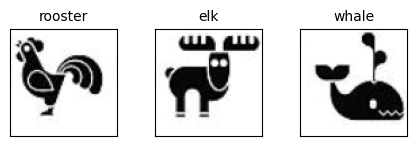

Binarized First 5 p6 Examples.


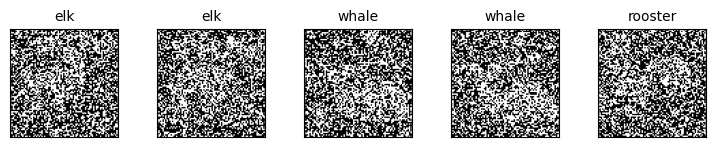

Reconstructed First 5 p6 Examples.


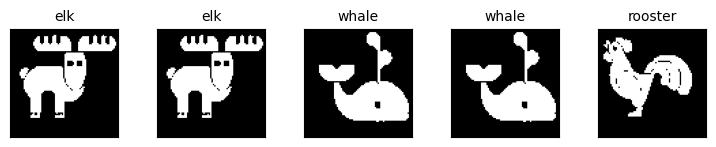

In [8]:
def reconstruct(Xtr, ytr, Xbin, ylabels, hopnet, num_imgs = 5, **kwargs):
    
    reconstructions = hopnet.predict(Xbin[:num_imgs], **kwargs)
    
    print(f"\nOriginal First 3 training Examples.")
    plot_gallery(Xtr.reshape((Xtr.shape[0],80,-1)), ytr)

    print(f"Binarized First {num_imgs} p6 Examples.")
    plot_gallery(Xbin[:num_imgs].reshape((num_imgs,80,-1)), ylabels[:num_imgs])

    print(f"Reconstructed First 5 p6 Examples.")
    plot_gallery(reconstructions.reshape((num_imgs,80,-1)), ylabels[:num_imgs])

reconstruct(Xtr, ytr, Xp6_binary, yp6, hopnet, sync = True, niter=100, verbose=False)

Note that the reconstructed images are essentially the original training images that were used to form the noisy images in p6 but 'inverted'. That is, where the original training images have pixel values equalling $1$ \- the reconstructed images of the p6 test set have pixel values equalling $0$ and vice versa. Hence, for my Hopfield Network to correctly classify these reconstructed images for the p6 test set, I predicted the label corresponding to the training image that minimized the following $l_1$-norm for a given noisy test example, $x_{test}$: $||x_{test} - x_{train}^{(i)}||_1$.